In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/auto-pian

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1jn_llb-3OnamAo89wMXsdDKi__iyjswV/auto-pian


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


In [3]:
# RELEVANT CONSTANTS
PATH_TO_DATASET_FOLDER = './PianoFingeringDataset_v1.2/PianoFingeringDataset_v1.2/FingeringFiles'
PATH_TO_METADATA = './PianoFingeringDataset_v1.2/PianoFingeringDataset_v1.2/List.csv'
FINGERING_TYPE_TO_ANALYZE = "1"


## NEED TO FIX: FINGERING_TYPE_TO_ANALYZE IS NOT CORRECT: NEED TO LOOK AT THE STRING NOT THE NUMEBR!!!!! 1 can be YI and ES for diff pieces!!!

# Setup
## Overview of the metadata

As can be seen from the metadata, we have a bunch of classical pieces by (old) composers. Basically how PIG works is that there are **8 fingerings** done by 8 different individuals: you want to make sure to **use fingerings from the SAME finger-er** in your training data for consistency!

In [4]:
# This cell loads in 'lists.csv', which is a simple CSV file that links IDs to actual pieces, with some extra metadata about the pieces themselves
song_metadata_dir_path = PATH_TO_METADATA

print(song_metadata_dir_path)
if os.path.isfile(song_metadata_dir_path):
    song_metadata_df = pd.read_csv(song_metadata_dir_path, skiprows=1, names=["id", "composer", "piece", "num_bars", "num_notes", "num_types_of_fingerings_provided", "fingering_1", "fingering_2", "fingering_3", "fingering_4", "fingering_5", "fingering_6", "fingering_7", "fingering_8"])
    print(song_metadata_df.head(10))
else:
    print("invalid filepath!")

./PianoFingeringDataset_v1.2/PianoFingeringDataset_v1.2/List.csv
   id composer                                              piece  num_bars  \
0   1     Bach                      Two-part invention in C major        22   
1   2     Bach                      Two-part invention in F major        34   
2   3     Bach  Well-Tempered Clavier, Book I, Prelude No. 23 ...        19   
3   4     Bach  Well-Tempered Clavier, Book II, Fugue No. 2 in...        14   
4   5     Bach  Well-Tempered Clavier, Book II, Fugue No. 19 i...        14   
5   6     Bach                             Partita No. 6 Corrente        38   
6   7     Bach                       French Suite No. 1 Allemande        12   
7   8     Bach                       French Suite No. 5 Sarabande        16   
8   9     Bach                        English Suite No. 3 Prelude        33   
9  10     Bach                  Goldberg Variations, Variation 13        16   

   num_notes  num_types_of_fingerings_provided fingering_1 finger

## Tokenize

AI models process floating point numbers. So we need to make sure all the fields are numbers, and so we establish this dictionary mapping:

In [5]:
directory_path = PATH_TO_DATASET_FOLDER

# every pitch is a combination of a note and octave
pitch_classes = ['Ab', 'A', 'A#', 'Bb', 'B', 'B#', 'Cb', 'C', 'C#', 'Db', 'D', 'D#', 'Eb', 'E', 'E#', 'Fb', 'F', 'F#', 'Gb', 'G', 'G#']
octaves = range(0, 9)
pitch_to_int_mapping = {f"{pc}{octave}": i for i, (pc, octave) in enumerate((pc, o) for o in octaves for pc in pitch_classes)}
int_to_pitch_mapping = {i: f"{pc}{octave}" for i, (pc, octave) in enumerate((pc, o) for o in octaves for pc in pitch_classes)}

fingerings = [
    '1', '2', '3', '4', '5',
    '1_', '2_', '3_', '4_', '5_',
    '-1', '-2', '-3', '-4', '-5',
    '1_2', '1_3', '1_4', '1_5',
    '1_-2', '1_-3', '1_-4', '1_-5',
    '2_1', '2_3', '2_4', '2_5',
    '2_-1', '2_-3', '2_-4', '2_-5',
    '3_1', '3_2', '3_4', '3_5',
    '3_-1', '3_-2', '3_-4', '3_-5',
    '4_1', '4_2', '4_3', '4_5',
    '4_-1', '4_-2', '4_-3', '4_-5',
    '5_1', '5_2', '5_3', '5_4',
    '5_-1', '5_-2', '5_-3', '5_-4',
    '-1_-2', '-1_-3', '-1_-4', '-1_-5',
    '-1_2', '-1_3', '-1_4', '-1_5',
    '-2_-3', '-2_-4', '-2_-5', '-2_-1',
    '-2_3', '-2_4', '-2_5', '-2_1',
    '-3_-4', '-3_-5', '-3_-2', '-3_-1',
    '-3_4', '-3_5', '-3_2', '-3_1',
    '-4_-5', '-4_-3', '-4_-2', '-4_-1',
    '-4_5', '-4_3', '-4_2', '-4_1',
    '-5_-1', '-5_-2', '-5_-3', '-5_-4',
    '-5_1', '-5_2', '-5_3', '-5_4',
    '1_2_3', '1_2_4', '1_2_5', '1_3_4', '1_3_5', '1_4_5', '2_3_4', '2_3_5', '2_4_5', '3_4_5',
    '-1_1', '-2_2', '-3_3', '-4_4', '-5_5', '1_-1', '2_-2', '3_-3', '4_-4', '5_-5', '0'
]
finger_to_int_mapping = {f: i for i, f in enumerate(fingerings)}
int_to_finger_mapping = {i: f for i, f in enumerate(fingerings)}


# verify that every finger and pitch in our data can be mapped correctly
verify_spelled_pitch_values = set()
verify_fingering_map = set()
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    if os.path.isfile(file_path):
        df = pd.read_table(file_path, sep="\t", skiprows=1, names=["noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity", "offset_velocity", "channel", "finger_number"])
        verify_spelled_pitch_values.update(df['spelled_pitch'].unique())
        verify_fingering_map.update(df['finger_number'].unique())
verify_fingering_map = {str(x) for x in verify_fingering_map}

if not verify_fingering_map.issubset(set(finger_to_int_mapping.keys())):
    print("INVALID FINGER SYMBOL DETECTED: ", verify_fingering_map - set(finger_to_int_mapping.keys()))
elif not verify_spelled_pitch_values.issubset(set(pitch_to_int_mapping.keys())):
    print("INVALID PITCH SYMBOL DETECTED: ", verify_spelled_pitch_values - set(pitch_to_int_mapping.keys()))
else:
    print("pitch_to_int_mapping: ", pitch_to_int_mapping)
    print("\n")
    print("finger_to_int_mapping: ", finger_to_int_mapping)


pitch_to_int_mapping:  {'Ab0': 0, 'A0': 1, 'A#0': 2, 'Bb0': 3, 'B0': 4, 'B#0': 5, 'Cb0': 6, 'C0': 7, 'C#0': 8, 'Db0': 9, 'D0': 10, 'D#0': 11, 'Eb0': 12, 'E0': 13, 'E#0': 14, 'Fb0': 15, 'F0': 16, 'F#0': 17, 'Gb0': 18, 'G0': 19, 'G#0': 20, 'Ab1': 21, 'A1': 22, 'A#1': 23, 'Bb1': 24, 'B1': 25, 'B#1': 26, 'Cb1': 27, 'C1': 28, 'C#1': 29, 'Db1': 30, 'D1': 31, 'D#1': 32, 'Eb1': 33, 'E1': 34, 'E#1': 35, 'Fb1': 36, 'F1': 37, 'F#1': 38, 'Gb1': 39, 'G1': 40, 'G#1': 41, 'Ab2': 42, 'A2': 43, 'A#2': 44, 'Bb2': 45, 'B2': 46, 'B#2': 47, 'Cb2': 48, 'C2': 49, 'C#2': 50, 'Db2': 51, 'D2': 52, 'D#2': 53, 'Eb2': 54, 'E2': 55, 'E#2': 56, 'Fb2': 57, 'F2': 58, 'F#2': 59, 'Gb2': 60, 'G2': 61, 'G#2': 62, 'Ab3': 63, 'A3': 64, 'A#3': 65, 'Bb3': 66, 'B3': 67, 'B#3': 68, 'Cb3': 69, 'C3': 70, 'C#3': 71, 'Db3': 72, 'D3': 73, 'D#3': 74, 'Eb3': 75, 'E3': 76, 'E#3': 77, 'Fb3': 78, 'F3': 79, 'F#3': 80, 'Gb3': 81, 'G3': 82, 'G#3': 83, 'Ab4': 84, 'A4': 85, 'A#4': 86, 'Bb4': 87, 'B4': 88, 'B#4': 89, 'Cb4': 90, 'C4': 91, 'C#4'

In [6]:
# EXAMPLE CODE: Loading in the "x" features and "y" label for a specific piece, using piece number 14 as an example

specific_piece_id = 14

for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)

    fingering_label, _ = filename.split('_')     # 001-01
    piece_id, fingering_type = fingering_label.split('-')
    piece_id = int(piece_id)
    fingering_type = int(fingering_type)

    if piece_id == specific_piece_id:
        df = pd.read_table(file_path, sep="\t", skiprows=1, names=["noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity", "offset_velocity", "channel", "finger_number"])

num_data, num_features = df.shape
x = df.iloc[:, 0:num_features - 1]
y = df.iloc[:, num_features - 1]


# convert "spelled pitch" field to a number
x['spelled_pitch'] = x['spelled_pitch'].map(pitch_to_int_mapping)

#  do same for "finger_number" label
y = y.map(finger_to_int_mapping)

x = torch.tensor(x.values.tolist(), dtype=torch.float32)
y = torch.tensor(y.values.astype(float).tolist())
y = y.unsqueeze(1)   # conver from size [289] to size [289, 1]

print(f"x's shape is {x.shape}")
print(f"y's shape is {y.shape}")
print(f"num features is {num_features} and num data is {num_data}")
# print(x)
# print(y)

x's shape is torch.Size([289, 7])
y's shape is torch.Size([289, 1])
num features is 8 and num data is 289


In [7]:
# Helper function for plotting finger differences
def plot_sequence_finger_predictions(x_axis, y_true, y_pred, model_name=''):
    plt.figure(figsize=(50, 5))
    sns.lineplot(x=x_axis, y=y_true, marker='o', markersize=8, label='Actual')
    sns.lineplot(x=x_axis, y=y_pred, marker='x', markersize=8, label='Predicted')

    plt.title(f"{model_name} Finger Predictions vs. Actual", fontsize=14)
    plt.xlabel("Note ID", fontsize=12)
    plt.ylabel("Finger Label", fontsize=12)
    plt.xticks(rotation=30)  # Slight rotation for readability
    plt.grid(True, linestyle='--', alpha=0.6)  # Light grid for reference
    plt.legend(fontsize=12)
    plt.show()

In [8]:
# EVAL TEST

from evaluation import FingeringEvaluator, evaluate_fingering_method
evaluator = FingeringEvaluator('./PianoFingeringDataset_v1.2/PianoFingeringDataset_v1.2')

ground_truth_fingerings, piece_ids, lengths = evaluator.load_test_data(
    pieces=['001', '002', '003'],  # this is where we would just load in all pieces in test set, for now you can specify which pieces
    annotator_ids=['1', '2'] # specify which annotators are considered in eval
)

predicted_fingerings = [[1] * len(gt) for gt in ground_truth_fingerings]

results = evaluate_fingering_method(
    predicted_fingerings,
    ground_truth_fingerings,
    piece_ids,
    lengths=lengths,
    method_name="repeated ones"
)


repeated ones Evaluation Results
General Match Rate (M_gen):      0.1326
Highest Match Rate (M_high):     0.1258
Soft Match Rate (M_soft):        0.1586



In [9]:
import os
import pandas as pd

TIME_WINDOW = 5.0  # seconds
MAX_NOTES = 30     # Maximum notes per sequence

# Define pad tokens: same as before.
PAD_X = [0, 0.0, 0.0, 0.0, 0.0, 0.0]
PAD_Y = 0

directory_path = PATH_TO_DATASET_FOLDER
all_sequences = []   # will hold raw DataFrames for each piece
all_piece_names = []
FINGERING_TYPE_TO_ANALYZE = 1

# Read in all pieces.
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    fingering_label, _ = filename.split('_')  # e.g. "001-01"
    piece_id, fingering_type = fingering_label.split('-')

    if os.path.isfile(file_path) and FINGERING_TYPE_TO_ANALYZE == int(fingering_type):
        df = pd.read_table(
            file_path, sep="\t", skiprows=1,
            names=[
                "noteID", "onset_time", "offset_time", "spelled_pitch",
                "onset_velocity", "offset_velocity", "channel",
                "finger_number"
            ]
        )
        all_piece_names.append(filename)
        all_sequences.append(df)

print(f"Total number of pieces found: {len(all_sequences)}")

raw_encoded_sequences_variant2 = []  # Each element is a tuple (X_seq, y_seq) of length MAX_NOTES

for df in all_sequences:
    X_list = []
    y_list = []
    onset_times = []
    # Build feature lists for the piece.
    for row in df.itertuples(index=False):
        spelled_pitch = row.spelled_pitch
        finger_str = str(row.finger_number)

        pitch_int = pitch_to_int_mapping.get(spelled_pitch, 0)
        finger_int = finger_to_int_mapping.get(finger_str, 0)
        feature_row = [
            pitch_int,
            float(row.onset_time),
            float(row.offset_time),
            float(row.onset_velocity),
            float(row.offset_velocity),
            float(row.channel)
        ]
        X_list.append(feature_row)
        y_list.append(finger_int)
        onset_times.append(float(row.onset_time))

    if len(X_list) == 0:
        continue

    # Create time windows starting at the first note and moving forward by TIME_WINDOW.
    t_start = onset_times[0]
    t_end = onset_times[-1]
    current_window_start = t_start

    while current_window_start <= t_end:
        # Collect indices of notes whose onset time falls within [current_window_start, current_window_start + TIME_WINDOW)
        indices = [i for i, t in enumerate(onset_times) if current_window_start <= t < current_window_start + TIME_WINDOW]
        if len(indices) == 0:
            # No notes in this window; move to the next window.
            current_window_start += TIME_WINDOW
            continue

        # If more than MAX_NOTES, keep only the first MAX_NOTES.
        indices = indices[:MAX_NOTES]
        X_seq = [X_list[i] for i in indices]
        y_seq = [y_list[i] for i in indices]

        # Pad the sequence to ensure it has exactly MAX_NOTES tokens.
        pad_len = MAX_NOTES - len(X_seq)
        # Here we pad on the right; if you prefer symmetric padding, adjust accordingly.
        X_seq = X_seq + [PAD_X] * pad_len
        y_seq = y_seq + [PAD_Y] * pad_len

        raw_encoded_sequences_variant2.append((X_seq, y_seq))

        # Advance the window by TIME_WINDOW seconds (non-overlapping segments).
        current_window_start += TIME_WINDOW

print("Variant 2: For a sample window, X sequence length =", len(raw_encoded_sequences_variant2[0][0]))


Total number of pieces found: 148
Variant 2: For a sample window, X sequence length = 30


In [10]:
SPECIFIC_VARIANT_TO_USE = raw_encoded_sequences_variant2
raw_encoded_sequences = SPECIFIC_VARIANT_TO_USE

In [11]:
print("x sequence length: ", len(raw_encoded_sequences[0][0]))
print("y sequence length (should match): ", len(raw_encoded_sequences[0][-1]))

# potentially do scaling/some kind of layernorm???
train_val_seqs, test_seqs = train_test_split(raw_encoded_sequences, test_size=0.2, random_state=42)
train_seqs, val_seqs = train_test_split(train_val_seqs, test_size=0.25, random_state=42)

print(f"Total pieces: {len(raw_encoded_sequences)}")
print(f"Train pieces: {len(train_seqs)}")
print(f"Val pieces:   {len(val_seqs)}")
print(f"Test pieces:  {len(test_seqs)}")

x sequence length:  30
y sequence length (should match):  30
Total pieces: 1080
Train pieces: 648
Val pieces:   216
Test pieces:  216


In [12]:
# DATASET LOADER CLASS

class FingeringDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X_list, y_list = self.sequences[idx]
        X_tensor = torch.tensor(X_list, dtype=torch.float32)  # (seq_len, 6)
        y_tensor = torch.tensor(y_list, dtype=torch.long)     # (seq_len,)
        return X_tensor, y_tensor

train_dataset = FingeringDataset(train_seqs)
val_dataset   = FingeringDataset(val_seqs)
test_dataset  = FingeringDataset(test_seqs)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=1, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=1, shuffle=False)


In [13]:
# training loop
def train_sequence_model(model, train_loader, val_loader, num_epochs=5, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for X_seq, y_seq in train_loader:
            # print("X_seq: ", X_seq)
            # print("y_seq: ", y_seq)

            X_seq = X_seq.to(device, non_blocking=True)
            y_seq = y_seq.to(device, non_blocking=True)

            optimizer.zero_grad()
            logits = model(X_seq)    # forward pass

            # reshape for CrossEntropy by flattening tokens => (batch_size * seq_len, num_fingers)
            logits_reshaped = logits.view(-1, logits.size(-1))
            y_seq_reshaped = y_seq.view(-1)

            loss = criterion(logits_reshaped, y_seq_reshaped)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        val_acc = evaluate_sequence_model(model, val_loader)
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | ValAcc: {val_acc:.4f}")

# doing inference for validation
def evaluate_sequence_model(model, data_loader):
    device = next(model.parameters()).device
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_seq, y_seq in data_loader:
            # X_seq: (batch_size, seq_len, num_features)
            # y_seq: (batch_size, seq_len)

            X_seq = X_seq.to(device, non_blocking=True)
            y_seq = y_seq.to(device, non_blocking=True)

            logits = model(X_seq)  # => (batch_size, seq_len, num_fingers)
            preds = torch.argmax(logits, dim=-1)  # => (batch_size, seq_len)

            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(y_seq.view(-1).cpu().numpy())

    return accuracy_score(all_labels, all_preds)


# TRANSFORMERS
Let's define the architecture for our transformer: first you need positional encodings, and add that to the main transformer model (since we don't handle variable length sequences: model needs to know position from the vector).

In [14]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        d_model: embedding size
        max_len: maximum sequence length
        """
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x shape: (seq_len, batch_size, d_model)
        Returns x + positional_encoding
        """
        seq_len = x.size(0)
        # Add the positional encoding to the input
        # shape => (seq_len, batch_size, d_model)
        x = x + self.pe[:seq_len, :].unsqueeze(1)
        return x


In [15]:
class MultiFeatureTransformerTagger(nn.Module):
    def __init__(
        self,
        num_pitches,      # vocabulary size for spelled_pitch
        num_fingers,      # number of finger classes
        pitch_emb_dim=64, # embedding dimension for pitch
        numeric_dim=5,    # number of numeric features (time, velocity, etc.)
        numeric_emb_dim=64,  # dimension to project numeric features
        nhead=4,
        num_layers=2,
        dim_feedforward=256,
        dropout=0.1
    ):
        super().__init__()

        self.pitch_embedding = nn.Embedding(num_pitches, pitch_emb_dim)      # pitch to embedding
        self.numeric_projection = nn.Linear(numeric_dim, numeric_emb_dim)    # all other numeric features => numeric_emb_dim

        self.d_model = pitch_emb_dim + numeric_emb_dim        # total embedding size = pitch_emb_dim + numeric_emb_dim
        self.pos_encoder = PositionalEncoding(d_model=self.d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=False  # (seq, batch, feature)
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Final linear layer: map each token embedding -> finger label
        self.fc = nn.Linear(self.d_model, num_fingers)

    def forward(self, x):
        """
        x shape: (batch_size, seq_len, 6)
          - x[..., 0]: pitch (int)
          - x[..., 1:]: numeric feats (float)
        Returns: (batch_size, seq_len, num_fingers)
        """
        pitch_ids = x[..., 0].long()        # (batch_size, seq_len)
        numeric_feats = x[..., 1:].float()  # (batch_size, seq_len, 5)

        # pitch_emb => (batch_size, seq_len, pitch_emb_dim)
        pitch_emb = self.pitch_embedding(pitch_ids)

        # numeric_emb => (batch_size, seq_len, numeric_emb_dim)
        numeric_emb = self.numeric_projection(numeric_feats)

        # combine => (batch_size, seq_len, d_model)
        combined_emb = torch.cat((pitch_emb, numeric_emb), dim=2)

        # transform to shape (seq_len, batch_size, d_model) for the Transformer
        combined_emb = combined_emb.transpose(0, 1)  # => (seq_len, batch_size, d_model)

        encoded = self.pos_encoder(combined_emb)

        transformer_out = self.transformer_encoder(encoded)  # => (seq_len, batch_size, d_model)

        logits = self.fc(transformer_out)
        logits = logits.transpose(0, 1)  # => (batch_size, seq_len, num_fingers)
        return logits


## Training the Transformer

Remember, this is using the data variant that is defined earlier!

In [ ]:
###############################################
# Train Transformer
###############################################
#   pitch_vocab = sorted set of pitches
#   finger_vocab = sorted set of finger labels
#   train_loader, val_loader, test_loader
#   Each batch => (X_seq, y_seq) with X_seq.shape=(batch_size, seq_len, 6)

import math
from torch.optim import Adam

transformer_model = MultiFeatureTransformerTagger(
    num_pitches=len(pitch_to_int_mapping),
    num_fingers=len(finger_to_int_mapping),
    pitch_emb_dim=12,       # dimension for pitch embedding
    numeric_dim=5,           # e.g. onset_time, offset_time, onset_vel, offset_vel, channel
    numeric_emb_dim=32,     # project numeric feats to 128
    nhead=2,
    num_layers=2,
    dim_feedforward=128,     # example dimension in feedforward
    dropout=0.05
)

# state_dict = torch.load('transformer_model_weights.pth')
# transformer_model.load_state_dict(state_dict)

print("\n=== Training Multi-Feature TRANSFORMER ===")
train_sequence_model(transformer_model, train_loader, val_loader, num_epochs=100, lr=1e-3)
test_acc_transformer = evaluate_sequence_model(transformer_model, test_loader)
print(f"Transformer Test Accuracy = {test_acc_transformer*100:.2f}%")
torch.save(transformer_model.state_dict(), "transformer_model_weights.pth")    # we save the RNN model weights at the very end so we can load them in later!

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



=== Training Multi-Feature TRANSFORMER ===
Epoch 1/100 | Loss: 2.1748 | ValAcc: 0.2353
Epoch 2/100 | Loss: 2.0540 | ValAcc: 0.2366
Epoch 3/100 | Loss: 2.0478 | ValAcc: 0.2551
Epoch 4/100 | Loss: 2.0439 | ValAcc: 0.2469
Epoch 5/100 | Loss: 1.9467 | ValAcc: 0.3242
Epoch 6/100 | Loss: 1.4836 | ValAcc: 0.3522
Epoch 7/100 | Loss: 1.4569 | ValAcc: 0.3648
Epoch 8/100 | Loss: 1.4356 | ValAcc: 0.3599
Epoch 9/100 | Loss: 1.4329 | ValAcc: 0.3657
Epoch 10/100 | Loss: 1.4213 | ValAcc: 0.3702
Epoch 11/100 | Loss: 1.4333 | ValAcc: 0.3707
Epoch 12/100 | Loss: 1.4189 | ValAcc: 0.3588
Epoch 13/100 | Loss: 1.4158 | ValAcc: 0.3884
Epoch 14/100 | Loss: 1.3886 | ValAcc: 0.4117
Epoch 15/100 | Loss: 1.3829 | ValAcc: 0.4150
Epoch 16/100 | Loss: 1.3436 | ValAcc: 0.4273
Epoch 17/100 | Loss: 1.3155 | ValAcc: 0.4574
Epoch 18/100 | Loss: 1.2827 | ValAcc: 0.4765
Epoch 19/100 | Loss: 1.2613 | ValAcc: 0.4647
Epoch 20/100 | Loss: 1.2244 | ValAcc: 0.4907
Epoch 21/100 | Loss: 1.2038 | ValAcc: 0.5046
Epoch 22/100 | Loss:

### TRANSFORMER MODEL ANNOTATION DEMO

Load in a specific .txt file and print out the transfomer's accuracy on that file. (you can access the predicted labels in rnn_pred_labels!)

In [ ]:
def predict_piece_fingerings_multi(
    model,
    file_path,
    pitch_to_idx,         # dict mapping spelled pitches -> int
    finger_to_idx=None,   # dict mapping finger labels -> int (optional)
    idx_to_finger=None,   # reverse mapping to decode predictions (optional)
    device=None
):
    df = pd.read_table(file_path, sep="\t", skiprows=1,
        names=[
            "noteID",
            "onset_time",
            "offset_time",
            "spelled_pitch",
            "onset_velocity",
            "offset_velocity",
            "channel",
            "finger_number",
        ],
    )

    # Encode spelled pitch -> int and finger labels -> int
    df["spelled_pitch_int"] = df["spelled_pitch"].map(pitch_to_int_mapping).fillna(0).astype(int)

    if finger_to_idx is not None:
        df["finger_int"] = df["finger_number"].astype(str).map(finger_to_int_mapping).fillna(0).astype(int)
        y_true = df["finger_int"].values
    else:
        y_true = None

    #    Construct multi-feature array X of shape (seq_len, 6)
    #    X[..., 0] = spelled_pitch_int (categorical)
    #    X[..., 1] = onset_time
    #    X[..., 2] = offset_time
    #    X[..., 3] = onset_velocity
    #    X[..., 4] = offset_velocity
    #    X[..., 5] = channel
    seq_len = len(df)
    X_array = np.zeros((seq_len, 6), dtype=np.float32)

    X_array[:, 0] = df["spelled_pitch_int"].astype(float)
    X_array[:, 1] = df["onset_time"].astype(float)
    X_array[:, 2] = df["offset_time"].astype(float)
    X_array[:, 3] = df["onset_velocity"].astype(float)
    X_array[:, 4] = df["offset_velocity"].astype(float)
    X_array[:, 5] = df["channel"].astype(float)

    X_tensor = torch.tensor(X_array, dtype=torch.float32).unsqueeze(0)    # convert X_array into a pytorch tensor

    # move everything to gpu if possible
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_tensor = X_tensor.to(device)
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        logits = model(X_tensor)
        preds = torch.argmax(logits, dim=-1).squeeze(0).cpu().numpy()

    if idx_to_finger:
        y_pred_labels = [int_to_finger_mapping.get(idx, "UNK") for idx in preds]
    else:
        y_pred_labels = preds
    acc = None
    y_true_labels = None
    if y_true is not None:
        from sklearn.metrics import accuracy_score
        acc = accuracy_score(y_true, preds) * 100.0
        if idx_to_finger:
            y_true_labels = [int_to_finger_mapping.get(idx, "UNK") for idx in y_true]

    return preds, y_true, y_pred_labels, y_true_labels, acc

In [ ]:
#   pitch_to_idx  : dict mapping spelled pitches -> int
#   finger_to_idx : dict mapping finger labels -> int
#   idx_to_finger : dict for decoding integer -> finger label

piece_file = "003-1_fingering.txt"
file_path = os.path.join(directory_path, piece_file)

transformer_preds, transformer_true, transformer_pred_labels, transformer_true_labels, transformer_acc = predict_piece_fingerings_multi(
    model=transformer_model,
    file_path=file_path,
    pitch_to_idx=pitch_to_int_mapping,
    finger_to_idx=finger_to_int_mapping,
    idx_to_finger=int_to_finger_mapping
)



print(f"\n=== Multi-Feature TRANSFORMER Predictions for {piece_file} ===")
# print("Predicted fingerings (string labels):", rnn_pred_labels)
if transformer_true is not None:
    print("Accuracy on this piece:", f"{transformer_acc:.2f}%")
    # print("Actual fingerings (string labels):  ", rnn_true_labels)



=== Multi-Feature TRANSFORMER Predictions for 003-1_fingering.txt ===
Accuracy on this piece: 32.85%


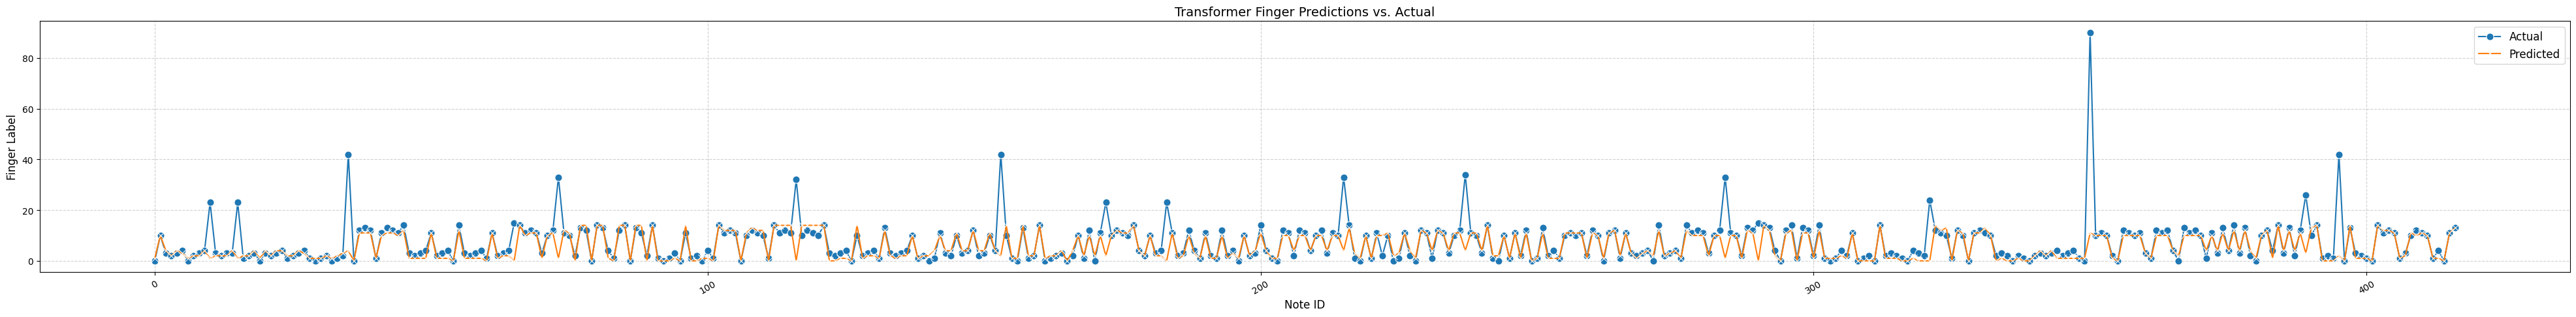

In [ ]:
def plot_sequence_finger_predictions(note_ids, y_true, y_pred, model_name="RNN"):
    plt.figure(figsize=(50, 5))
    sns.lineplot(x=note_ids, y=y_true, marker='o', markersize=8, label='Actual')
    sns.lineplot(x=note_ids, y=y_pred, marker='x', markersize=8, label='Predicted')
    plt.title(f"{model_name} Finger Predictions vs. Actual", fontsize=14)
    plt.xlabel("Note ID", fontsize=12)
    plt.ylabel("Finger Label", fontsize=12)
    plt.xticks(rotation=30)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    plt.show()

plot_sequence_finger_predictions(
    note_ids=np.arange(len(transformer_true)),
    y_true=transformer_true,
    y_pred=transformer_preds,
    model_name="Transformer"
)

In [ ]:
ground_truth_fingerings, piece_ids, lengths = evaluator.load_test_data(
    pieces=['003'],  # this is where we would just load in all pieces in test set, for now you can specify which pieces
    annotator_ids=['1', '2', '8'] # specify which annotators are considered in eval
)

print(transformer_preds)
print(ground_truth_fingerings)

predicted_fingerings = [transformer_preds.tolist()]

results = evaluate_fingering_method(
    predicted_fingerings,
    ground_truth_fingerings,
    piece_ids,
    lengths=lengths,
    method_name="transformer 003-1"
)

[ 1 10  4  2  4  3  1  2  2  4  1  2  2  2  4  1  2  2  4  1  4  2  4  4
  2  2  4  3  1  1  1  2  1  2  3  4  0 11 11 11  1 10 11 11 10 12  1  1
  1  1 11  1  1  1  0 12  1  1  1  1  0 11  1  2  2  0 14 10 11 11  1 10
 11  1 12 11  0 14 14  0 14 14  1  0 14 14  0 14 14  0 14  0  0  0  1  0
 14  0  0  1  1  0 14 12 12 12  0 11 13 12 12  0 14 14 14 14  0 14 14 14
 14 14  0  0  1  1  0 14  1  2  2  1 12  2  1  2  2 10  1  2  2  4 10  4
  4 11  4  4 12  4  4 11  4  2 14  1  1 14  2  2 14  1  2  2  4  0  4 10
  2 10  2 10  2 10 12 11 11 14  4  2 10  2  2  0 11  1  2 10  3  1 10  1
  1 10  1  3  1 10  2  4 11  4  1  1 10 10  4 10 10  4 10 10  4 10 10  4
 13  3  1 10  1 10 10 11  2  3 11  4  1 12 11  4 12 11  4 11 11  4 11 11
  4 14  2  2 10  1 11  1 11  0  1 11  1  1  1 11 11 11 11  1 11 10  1 11
 12  2 11  3  1  3  4  2 12  2  3  4  1 12 10 10 10  2 10 10  1 10 10  1
 12 11  0 14 12  2  0 11 12  0 11 11  1 12  1  1  1  2  1 11  0  0  0  0
 14  1  1  1  0  0  1  0  0  0 14 12 13  0 12 11  0

# Hierarchical Transformer

# RANDOM USEFUL CODE EXAMPLES BELOW:
## How to load in a bunch of sequences from a specific file

In [ ]:
sequence_length = 10  # Define the sequence length

for filename in os.listdir(directory_path)[:5]:  # Iterate through files
    file_path = os.path.join(directory_path, filename)

    fingering_label, _ = filename.split('_')  # Extract piece and fingering type
    piece_id, fingering_type = fingering_label.split('-')
    piece_id = int(piece_id)
    fingering_type = int(fingering_type)

    # Load the data
    df = pd.read_table(file_path, sep="\t", skiprows=1, names=[
        "noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity",
        "offset_velocity", "channel", "finger_number"
    ])

    # Separate features and labels
    num_data, num_features = df.shape
    x = df.iloc[:, 0:num_features - 1]
    y = df.iloc[:, num_features - 1]
    x['spelled_pitch'] = x['spelled_pitch'].map(pitch_to_int_mapping)  # Map pitch to integers
    y = y.map(finger_to_int_mapping)  # Map finger labels to integers

    # Create sequences
    x_sequences, y_sequences = create_sequences(x, y, sequence_length=sequence_length)

    print(f"x_sequences shape: {x_sequences.shape}")
    print(f"y_sequences shape: {y_sequences.shape}")


x_sequences shape: (280, 10, 7)
y_sequences shape: (280, 10)
x_sequences shape: (582, 10, 7)
y_sequences shape: (582, 10)
x_sequences shape: (339, 10, 7)
y_sequences shape: (339, 10)
x_sequences shape: (184, 10, 7)
y_sequences shape: (184, 10)
x_sequences shape: (252, 10, 7)
y_sequences shape: (252, 10)


## Fitting a logistic regression model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Initialize lists to accumulate all training data
X = []
Y = []

sequence_length = 5  # Define the sequence length

# Iterate through files
for filename in os.listdir(directory_path)[:100]:  # Process the first 10 files
    file_path = os.path.join(directory_path, filename)

    fingering_label, _ = filename.split('_')  # Extract piece and fingering type
    piece_id, fingering_type = fingering_label.split('-')
    piece_id = int(piece_id)
    fingering_type = int(fingering_type)

    # Load the data
    df = pd.read_table(file_path, sep="\t", skiprows=1, names=[
        "noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity",
        "offset_velocity", "channel", "finger_number"
    ])

    # Separate features and labels
    num_data, num_features = df.shape
    x = df.iloc[:, 0:num_features - 1]
    y = df.iloc[:, num_features - 1]
    x['spelled_pitch'] = x['spelled_pitch'].map(pitch_to_int_mapping)  # Map pitch to integers
    y = y.map(finger_to_int_mapping)  # Map finger labels to integers

    # Create sequences
    x_sequences, y_sequences = create_sequences(x, y, sequence_length=sequence_length)

    # Flatten x_sequences into [num_sequences * sequence_length, num_features]
    num_sequences, seq_len, num_features = x_sequences.shape
    x_flat = x_sequences.reshape(num_sequences * seq_len, num_features)  # Flatten sequences
    y_flat = y_sequences.flatten()  # Flatten y_sequences to match x_flat

    # Append to global X and Y
    X.append(x_flat)
    Y.append(y_flat)

# Concatenate all data into single arrays
X = np.vstack(X)  # Combine all x_flat into a single array
Y = np.concatenate(Y)  # Combine all y_flat into a single array

# Fit a logistic regression model to the combined data
logistic_model = LogisticRegression(max_iter=500, solver='lbfgs', multi_class='multinomial')  # Multinomial for multi-class classification
logistic_model.fit(X, Y)

# Predict on training data
Y_pred = logistic_model.predict(X)

# Compute and print metrics
accuracy = accuracy_score(Y, Y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{classification_report(Y, Y_pred)}")
print(f"X shape: {X.shape}, Y shape: {Y.shape}")


/home/willy/Desktop/projects/smolgrad/smol/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Overall Accuracy: 0.2016
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.19      0.83      0.31     15753
           2       0.16      0.15      0.15     14228
           3       0.00      0.00      0.00     11627
           4       0.00      0.00      0.00      9013
           5       0.20      0.01      0.01      9111
           6       0.14      0.07      0.09      6734
           7       0.00      0.00      0.00      3388
           8       0.00      0.00      0.00        15
           9       0.00      0.00      0.00         5
          11       0.00      0.00      0.00        20
          12       0.00      0.00      0.00      3847
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00        35
          17       0.00      0.00      0.00        15
          19       0.00      0.00

/home/willy/Desktop/projects/smolgrad/smol/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/willy/Desktop/projects/smolgrad/smol/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/willy/Desktop/projects/smolgrad/smol/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

# Load the piece and preprocess
file_path = os.path.join(directory_path, "001-1_fingering.txt")  # Replace with your piece file name

df = pd.read_table(file_path, sep="\t", skiprows=1, names=[
    "noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity",
    "offset_velocity", "channel", "finger_number"
])

# Preprocess features
x = df.iloc[:, :-1]
y = df.iloc[:, -1]
x['spelled_pitch'] = x['spelled_pitch'].map(pitch_to_int_mapping)  # Map pitch to integers
y = y.map(finger_to_int_mapping)  # Map finger labels to integers

# Create sequences with padding if needed
def create_sequences_with_padding(x_df, sequence_length=10):
    """
    Create sequences with padding if the number of rows is not divisible by the sequence length.
    """
    num_notes, num_features = x_df.shape
    padded_length = ((num_notes + sequence_length - 1) // sequence_length) * sequence_length  # Round up
    padding_needed = padded_length - num_notes

    # Add zero padding to the end of the DataFrame
    x_padded = np.pad(x_df.values, ((0, padding_needed), (0, 0)), mode="constant", constant_values=0)

    # Reshape into sequences
    x_sequences = x_padded.reshape(-1, sequence_length, num_features)
    return x_sequences, num_notes  # Return original number of notes for truncation later

sequence_length = 10
x_sequences, original_num_notes = create_sequences_with_padding(x, sequence_length=sequence_length)

# Flatten sequences for prediction
num_sequences, seq_len, num_features = x_sequences.shape
x_flat = x_sequences.reshape(num_sequences * seq_len, num_features)

# Predict fingerings
predicted_fingerings = logistic_model.predict(x_flat)

# Reshape predictions to match sequence structure
predicted_fingerings = predicted_fingerings.reshape(num_sequences, seq_len)

# Truncate padded predictions to match original number of notes
predicted_fingerings = predicted_fingerings.flatten()[:original_num_notes]  # Remove padding

# Output predicted fingerings
print("Predicted Fingerings:")
print(predicted_fingerings)
print(y.to_numpy())

# Compute and print metrics
accuracy = accuracy_score(Y, Y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{classification_report(Y, Y_pred)}")
print(f"X shape: {X.shape}, Y shape: {Y.shape}")

Predicted Fingerings:
[ 1  1  1  1  1  1  1 46 55  1 55 55  1 55  1  1 55  1 55 55  1 55  1  1
 55  1  1  1  1  1  1 55  1 55 55  1 55  1  1 55  1 55 55  1 55  1  1 55
  1  1 55  1  1 55  1  1 55  1  1 55  1  1 55  1  1 55  1  1 55  1  1 55
  1  1 55  1  1 55  1  1 55  1  1 55  1  1 55  1  1  1  0 55  1 55 55  1
 55  1  1 55 55  1 55  1 55  1  1 55  1  1 55  1  1 55  1  1 55  1  1 55
  1  1 55  1  1 55  1  1 55  1  1  1  1 55  1 55  1  1  1 55  1  1 55 57
 55 55 57 55 55 55  1  1 55  1  1 55  1  1 55  1  1 57 55 55 55 55 55 55
 55 57  1  1 55  1  1 55  1  1 55  1  0 55 55 55 55 55 55 55 55 55  1  1
 55  1  1 55  1  1 55  1  0 55 57 55 55 55 55 55 57 55  1  1 55  1  1 55
  1  1 55  1  1 55 57  0 57 55  1 55 57  1 55 57  1 57 55  0 55 55  0 55
 55  0 55 55  0 55 55  1 55 55  1 57 55  0 55 55  0 55 55  0 57 57  0 55
 57 57 55 57  1  1 55  1  0 55 57  1 55  1  1  1 57  1 57  1 57  1 55  1
 55  1 57  0 55  1 57  1 57  0 57  1 57  0 57  0 57  1 55  1 57  1 55  1
 55  1  1 57  1  1 55  1  1  

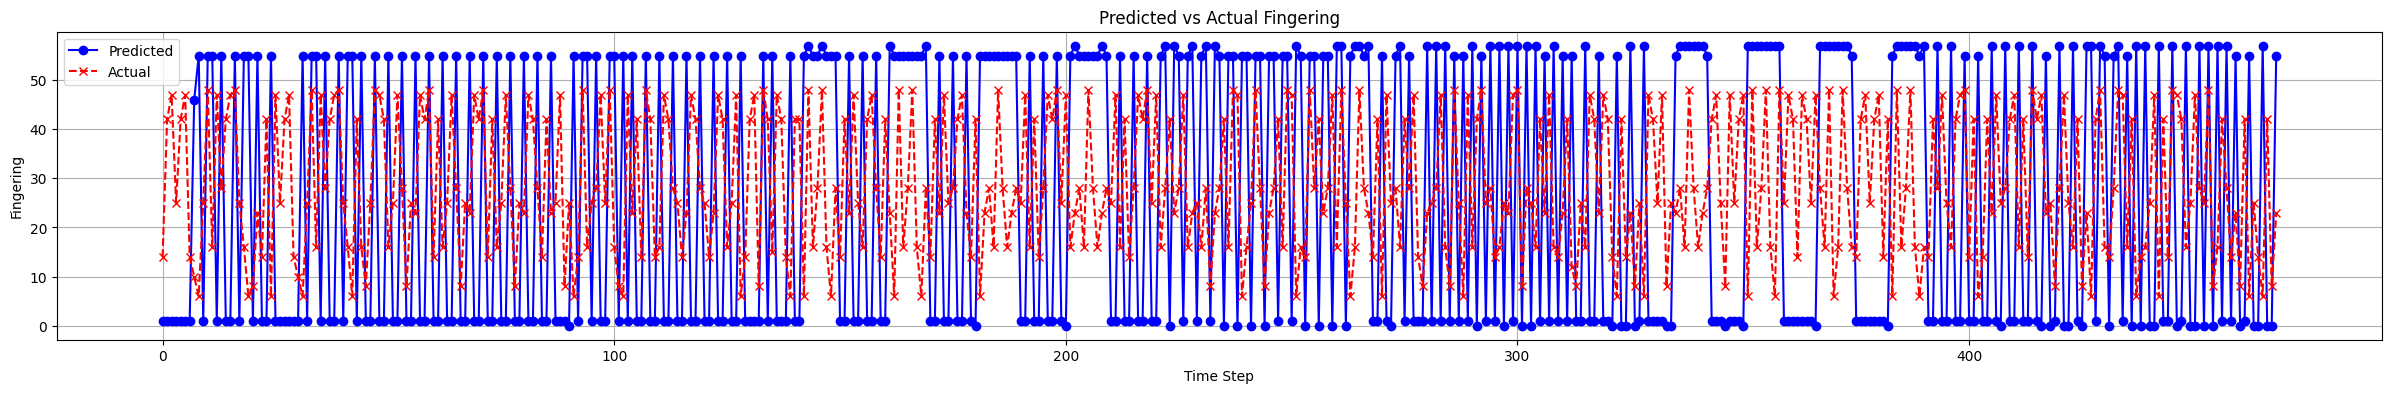

In [ ]:
# VISUALIZATION:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Step 6: Visualize the predictions vs actual labels
def visualize_comparison(preds, actuals):
    fig, ax = plt.subplots(figsize=(30, 4))
    x = range(len(preds))
    ax.plot(x, preds, label='Predicted', marker='o', linestyle='-', color='b')
    ax.plot(x, actuals, label='Actual', marker='x', linestyle='--', color='r')

    ax.set_xlabel('Time Step')
    ax.set_ylabel('Fingering')
    ax.set_title('Predicted vs Actual Fingering')
    ax.legend()
    plt.grid(True)
    plt.show()

# Visualize comparison for a few sequences
visualize_comparison(predicted_fingerings, y.to_numpy())